#### Using WIN M1 Metatrader 5 data

Implementing Saulo's arbitrage algo

The idea is to train a guided system that learns and ajusts itself with its owns errors.  
That's the idea of a kalman's filter.   
The base for the first decision is the Bollinger Bands Algo.  
That's the most powerfull algo, based on the regression toward the mean law!

In [1]:
%matplotlib inline 

In [2]:
pwd

'C:\\Users\\alferreira\\Documents\\stocks\\prototypes'

In [3]:
cd ..

C:\Users\alferreira\Documents\stocks


In [4]:
from matplotlib import pyplot as plt
import os
import sys
import pandas as pd
import numpy as np
import struct
import datetime
import calendar
import time
import argparse
import seaborn as sns
from algos import meta5Ibov
from algos.util import progressbar
from algos import meta5Ibov, bbands3, bbands2
import importlib
from matplotlib import pyplot as plt
from sklearn.ensemble import ExtraTreesClassifier
from sklearn import svm
import scipy
import talib as ta
from numba import jit
import importlib

In [22]:
importlib.reload(bbands3)
importlib.reload(bbands2)

<module 'algos.bbands2' from 'C:\\Users\\alferreira\\Documents\\stocks\\algos\\bbands2.py'>

In [6]:
cd data

C:\Users\alferreira\Documents\stocks\data


In [7]:
meta5Ibov.setDataPath(r'C:\\Users\\alferreira\\Documents\\stocks\\data', 
                     r'C:\\Users\\alferreira\\Documents\\stocks\\data')
# meta5Ibov.setDataPath(r'/home/andre/Projects/stocks/data', 
#                         r'/home/andre/Projects/stocks/data')


Master data loaded size (minutes):  509471
symbols loaded:
['ABEV3' 'B3SA3' 'BBAS3' 'BBDC4' 'DOL$' 'ITUB4' 'PETR4' 'VALE3' 'WIN@']


#### Using WIN M1 Metatrader 5 data

Implementing Saulo's arbitrage algo

The idea is to train a guided system that learns and ajusts itself with its owns errors.  
That's the idea of a kalman's filter.   
The base for the first decision is the Bollinger Bands Algo.  
That's the most powerfull algo, based on the regression toward the mean law!

### all day data

In [8]:
meta5Ibov.symbols

0    ABEV3
1    B3SA3
2    BBAS3
3    BBDC4
4     DOL$
5    ITUB4
6    PETR4
7    VALE3
8     WIN@
dtype: object

In [10]:
loaded = meta5Ibov.loadMeta5Data(suffix='M1.mt5bin', verbose=False)
barsread = meta5Ibov.getSymbol('WIN@')

Using previous loaded data!


In [11]:
len(barsread)

509471

He used 50 training samples (or signals)  
Window of 180 and batchn of 180  

In [13]:
nbands=6
window=21
batchn=32 # previous samples of signals to store 
twindow=42

### Those things dont change  during day operation

removed normalization over raw bollinger band signals

In [55]:
bars = bbands2.rawSignals(barsread, window, nbands, inc=0.5, save=False)
bars = bbands2.dayFeatures(bars)
#isgfeatures, bars = bbands3.standardizeFeatures(bars, nbands)

In [56]:
del bars['S']

In [57]:
bars.head(2)

,O,H,L,C,TV,RV,OHLC,bandsg0,bandsg1,bandsg2,bandsg3,bandsg4,bandsg5,date,dated
time,,,,,,,,,,,,,,,
2014-01-02 10:06:00,80088.0,80118.0,80049.0,80088.0,1690,481,80085.75,0,0,0,0,0,0,16072,1
2014-01-02 10:07:00,80080.0,80080.0,80034.0,80049.0,670,184,80060.75,0,0,0,0,0,0,16072,1


In [58]:
len( bars[ bars.bandsg1 == 1 ])/len(bars)

0.0251888723793896

In [59]:
len( bars[ bars.bandsg0 == 1 ])/len(bars)

0.03202537534030396

In [60]:
bars.columns

Index(['O', 'H', 'L', 'C', 'TV', 'RV', 'OHLC', 'bandsg0', 'bandsg1', 'bandsg2',
       'bandsg3', 'bandsg4', 'bandsg5', 'date', 'dated'],
      dtype='object')

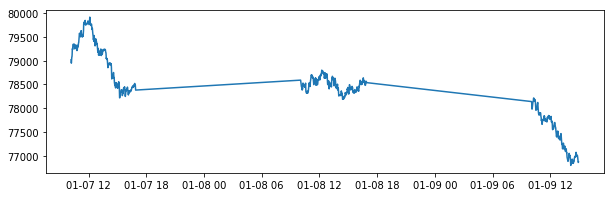

In [61]:
plt.figure(figsize=(10,3))
plt.plot(bars.OHLC[1180:2240])

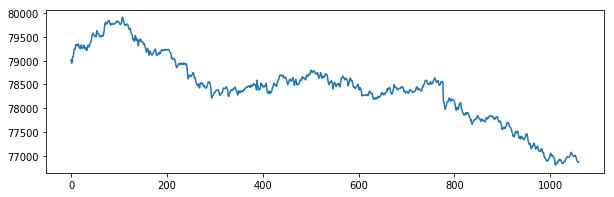

In [62]:
plt.figure(figsize=(10,3))
plt.plot(bars.OHLC[1180:2240].values)

In [63]:
bars = bars[1180:] # starting in a monday

Create truth target class before daily operations start

In [66]:
truthbars = bbands3.targetFromSignals(bars, window, nbands) 
iys = ['y'+str(i) for i in range(nbands)]
# the truth vector is in here
ytrue = bbands3.sumdPred(truthbars[iys])
del truthbars

In [67]:
# create bands signals that will filled initially only for initial training piece 
# cannot delete future signals they will only be overwriten
# for j in range(nbands): # for each band traverse it
#     bars.loc[:, 'bandsg'+str(i)] = 0 # signal for all bands
# y target classes will be created based on then so no need to worry about the target class

### Initial training stage for first model

In [68]:
barscg = bars.copy() # the band signals will be modified

In [69]:
#barscg = barscg[445000:]

In [70]:
def trainModel(obars, window, nbands, batchn, verbose=False):
    # the truth vector is in here for the training set 
    bars = bbands3.TargetFromSignals(obars, window, nbands) 
    X, y, itime = bbands2.getTrainingVectors(bars, window, nbands, batchn)     
    trees = None # in case cannot create new model
    if verbose:
        print("trainig vectors: {:<5d}".format(len(X)))        
    if len(np.unique(y)) < 3:
        print('warning not enough classes')        
        print(np.unique(y))
    else:
        #trees = svm.SVC(kernel='rbf', random_state=0)
        trees = ExtraTreesClassifier(n_estimators=70, verbose=0)
        trees.fit(X, y)
    return trees, bars

In [71]:
# %%time
# ys = bars.iloc[:, iyband].values
# iXy = np.argwhere(~np.isnan(ys))
# y = np.zeros(iXy.shape[0])
# y = ys[iXy[:, 0], iXy[:, 1]]

The first target classes were filled  
X, y vectors can be assembly anytime from this initial part  
of the bars data-frame  

 529/60 # 8++ hours to get the firs 50 training samples

In [72]:
nbg = 700

In [73]:
bars.head()

,O,H,L,C,TV,RV,OHLC,bandsg0,bandsg1,bandsg2,bandsg3,bandsg4,bandsg5,date,dated
time,,,,,,,,,,,,,,,
2014-01-07 10:12:00,79108.0,79108.0,78923.0,78938.0,7160,1978,79019.25,0,0,0,0,0,0,16077,0
2014-01-07 10:13:00,78923.0,78977.0,78915.0,78977.0,2150,530,78948.00,0,0,0,0,0,0,16077,0
2014-01-07 10:14:00,78969.0,79023.0,78969.0,79008.0,880,230,78992.25,1,1,0,0,1,0,16077,0
2014-01-07 10:16:00,79069.0,79100.0,79062.0,79085.0,660,182,79079.00,2,2,1,1,0,2,16077,0
2014-01-07 10:17:00,79085.0,79092.0,79069.0,79085.0,340,95,79082.75,0,0,2,0,2,0,16077,0


In [74]:
# y target class column index
#iybands = np.array([ bars.columns.get_loc('y'+str(j)) for j in range(nbands)], dtype=int)
isgfeatures = np.arange(len(bars.columns), dtype=int)
#isgfeatures = np.delete(isgfeatures, iybands) # everything less y's

### every new 50 signals train a new model using all training samples

In [75]:
ibandsgs = [ bars.columns.get_loc('bandsg'+str(j)) for j in range(nbands) ]

In [76]:
i = nbg

In [77]:
model, barstrain = trainModel(barscg[i-nbg:i], window, nbands, batchn, True)
barscg[i-nbg:i] = barstrain[:]

trainig vectors: 111  


In [78]:
def runday(bars, nbg=700): # day is 7*60 minutes
    ibandsgs = [ bars.columns.get_loc('bandsg'+str(j)) for j in range(nbands) ]
    ypred = []
    newmodel = []
    barscg = bars.copy()
    i = nbg
    # first training 
    model, barstrain = trainModel(barscg[i-nbg:i], window, nbands, batchn, True)
    barscg[i-nbg:i] = barstrain[:]
    for i in range((nbg, nbg+7*60)):
        if i%(30*7*3)==0: # lets forget older samples for a new model
            # have to use bars because the previous model was putting everything to zero
            model, barstrain = trainModel(bars[i-nbg:i], window, nbands, batchn, False)
            barscg[i-nbg:i] = barstrain[:]
            newmodel.append(i)
        signal = barscg.iloc[i, ibandsgs].values # get signal
        if np.sum(signal) == 0: # neeed to save which bands will get the y by the model prediction
            continue
        # put in the model the new signal and get the output
        Xnew = barscg.iloc[-batchn+i+1:i+1, isgfeatures].values.flatten()
        ynew = model.predict(Xnew.reshape(1,-1))   
        yprob = model.predict_proba(Xnew.reshape(1,-1))   
        ynew = ynew[0]
        ypred.append([i, ynew, *yprob])
        #print(signal, ynew[0])
        signal = signal/max(signal)    
        # save for each band the predicted  signal
        barscg.iloc[i, ibandsgs] = signal*ynew # OVERWRITE THE ORIGINAL SIGNAL BY THE PREDICTION
        if i%25 == 0: # new 25 training samples time to train again
            nmodel, barstrain = trainModel(barscg.iloc[i-2*nbg:i+1], window, nbands, batchn, False)
            if nmodel is not None: # maybe cannot train not enough classes
                model = nmodel  # maybe should create a plain new model but let it be
            barscg.iloc[i-2*nbg:i+1] = barstrain 
    return ypred, newmodel

In [79]:
ypred = []
newmodel = []
for i in progressbar(range(nbg, 20000)): # for each minute    
    if i%(30*7*3)==0: # lets forget older samples for a new model
        # have to use bars because the previous model was putting everything to zero
        model, barstrain = trainModel(bars[i-nbg:i], window, nbands, batchn, False)
        barscg[i-nbg:i] = barstrain[:]
        newmodel.append(i)
    signal = barscg.iloc[i, ibandsgs].values # get signal
    if np.sum(signal) == 0: # neeed to save which bands will get the y by the model prediction
        continue
    # put in the model the new signal and get the output
    Xnew = barscg.iloc[-batchn+i+1:i+1, isgfeatures].values.flatten()
    ynew = model.predict(Xnew.reshape(1,-1))   
    yprob = model.predict_proba(Xnew.reshape(1,-1))   
    ynew = ynew[0]
    ypred.append([i, ynew, *yprob])
    #print(signal, ynew[0])
    signal = signal/max(signal)    
    # save for each band the predicted  signal
    barscg.iloc[i, ibandsgs] = signal*ynew # OVERWRITE THE ORIGINAL SIGNAL BY THE PREDICTION
    if i%25 == 0: # new 25 training samples time to train again
        nmodel, barstrain = trainModel(barscg.iloc[i-2*nbg:i+1], window, nbands, batchn, False)
        if nmodel is not None: # maybe cannot train not enough classes
            model = nmodel  # maybe should create a plain new model but let it be
        barscg.iloc[i-2*nbg:i+1] = barstrain 

warning not enough classes.......................................................] 50/19300
[]
warning not enough classes.......................................................] 75/19300
[]
warning not enough classes.......................................................] 300/19300
[]
warning not enough classes.......................................................] 450/19300
[]
warning not enough classes.......................................................] 500/19300
[]
warning not enough classes.......................................................] 525/19300
[]
warning not enough classes.......................................................] 675/19300
[]
[################################################################################] 19300/19300


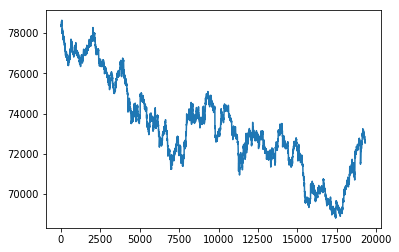

In [80]:
plt.plot(barscg.iloc[nbg:i].OHLC.values)

In [81]:
assert np.any(barscg.iloc[nbg:i+1, ibandsgs].values != bars.iloc[nbg:i+1, ibandsgs].values)

In [82]:
results = []
for row in ypred:
    a, b, probs = row
    prob0, prob1, prob2 = probs
    results.append([a, b, prob0, prob1, prob2])

In [83]:
df = pd.DataFrame(results, columns=['idx', 'ypred', 'prob0', 'prob1', 'prob2'])

In [84]:
df.head()

,idx,ypred,prob0,prob1,prob2
0,706,2,0.428571,0.128571,0.442857
1,707,2,0.371429,0.114286,0.514286
2,717,2,0.428571,0.128571,0.442857
3,718,0,0.442857,0.171429,0.385714
4,719,0,0.485714,0.142857,0.371429


C:\Users\alferreira\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


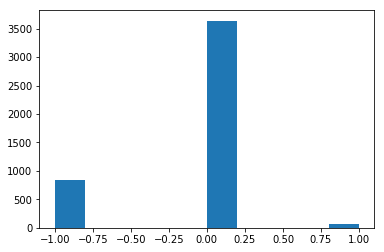

In [85]:
df.ypred.loc[ df.ypred == 2] = -1
plt.hist(df.ypred);

In [86]:
ys = ytrue.copy()
ys = ys[df.idx]

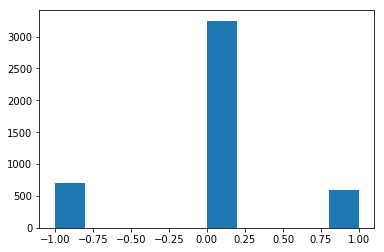

In [87]:
plt.hist(ys);

In [88]:
from sklearn import metrics

In [89]:
print(metrics.classification_report(ys, df.ypred))

              precision    recall  f1-score   support

        -1.0       0.21      0.24      0.22       707
         0.0       0.72      0.81      0.76      3248
         1.0       0.25      0.03      0.05       597

   micro avg       0.62      0.62      0.62      4552
   macro avg       0.39      0.36      0.35      4552
weighted avg       0.58      0.62      0.59      4552



In [90]:
len(ys), len(df.ypred)

(4552, 4552)

In [91]:
print(metrics.classification_report(ys[nbg:], df.ypred[nbg:]))

              precision    recall  f1-score   support

        -1.0       0.20      0.24      0.22       592
         0.0       0.72      0.81      0.76      2756
         1.0       0.21      0.03      0.05       504

   micro avg       0.62      0.62      0.62      3852
   macro avg       0.38      0.36      0.34      3852
weighted avg       0.58      0.62      0.59      3852



### Only class1 predictions

In [92]:
idx1 = np.argwhere(df.ypred.values == 1)
idx1 = idx1.flatten()
yp1 = df.ypred[idx1]
ys1 = ys[idx1]

In [93]:
ys1[ys1 != 1] = 0

In [94]:
np.unique(ys1), np.unique(yp1)

(array([0., 1.]), array([1], dtype=int64))

In [95]:
acc = (ys1.values-yp1.values)+1

In [96]:
#acc = acc.flatten()

In [97]:
len(ys1), len(yp1), len(acc)

(72, 72, 72)

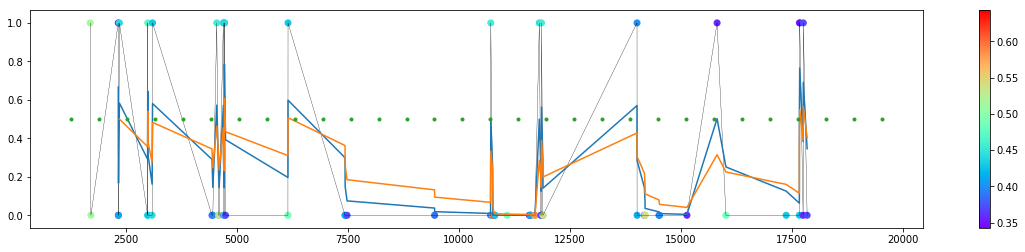

In [98]:
plt.figure(figsize=(20,4))
plt.scatter(df.iloc[idx1].idx, acc, c=df.iloc[idx1].prob1.values, cmap='rainbow')
plt.plot(df.iloc[idx1].idx, acc, 'k-', lw=0.3)
plt.plot(df.iloc[idx1].idx, ta.EMA(acc.flatten(), 3))
plt.plot(df.iloc[idx1].idx, ta.EMA(acc.flatten(), 6))
plt.plot(newmodel, 0.5*np.ones(len(newmodel)), '.')
#plt.xlim(30000, 50000)
plt.colorbar()

#### Analysing entries by pattern of correct predictions 

what if 3 correct entries gives an entry point 

In [99]:
np.round(df.iloc[idx1].prob1.values[:100], 2)

array([0.51, 0.51, 0.36, 0.36, 0.41, 0.44, 0.47, 0.47, 0.43, 0.44, 0.43,
       0.37, 0.4 , 0.46, 0.46, 0.54, 0.44, 0.39, 0.44, 0.39, 0.44, 0.37,
       0.49, 0.43, 0.41, 0.41, 0.37, 0.49, 0.39, 0.4 , 0.46, 0.49, 0.47,
       0.59, 0.5 , 0.64, 0.53, 0.61, 0.54, 0.61, 0.37, 0.43, 0.49, 0.36,
       0.39, 0.4 , 0.41, 0.53, 0.59, 0.44, 0.37, 0.37, 0.46, 0.41, 0.54,
       0.4 , 0.41, 0.36, 0.5 , 0.54, 0.4 , 0.4 , 0.36, 0.36, 0.49, 0.43,
       0.43, 0.41, 0.34, 0.36, 0.37, 0.37])

In [100]:
import seaborn as sns

In [101]:
len(acc), len(df.iloc[idx1].prob1.values)

(72, 72)

C:\Users\alferreira\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


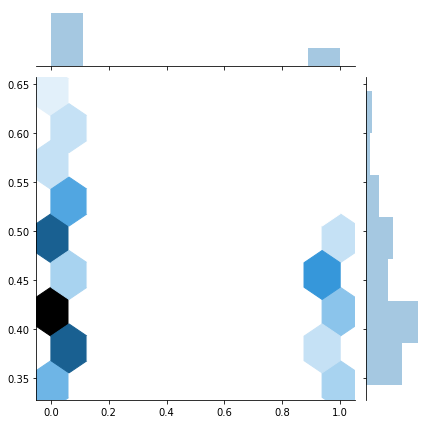

In [102]:
sns.jointplot(acc, df.iloc[idx1].prob1.values, kind='hex')

In [103]:
acc[:100]

array([1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1.,
       0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       1., 0., 1., 0.])

In [104]:
np.convolve(acc[:100], [1], mode='same')

array([1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1.,
       0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       1., 0., 1., 0.])

In [195]:
ones = np.convolve(acc, [1, 1], mode='same')

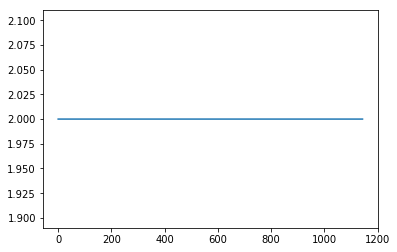

In [184]:
plt.plot(np.clip(ones, 2, 4))

In [191]:
def cmpcorrecpred(a, b, code=2):
    if a == b and a == code:
        return True
    return False

def cmpfalsepred(a, b):
    if b == 2 and a != 1:
        return True
    return False

ncorrects = list(map(cmpcorrecpred, ones[1:], ones[:]))
nwrongs = list(map(cmpfalsepred, ones[1:], ones[:]))

#### Number of correct predictions

In [192]:
np.count_nonzero(ncorrects)

114

In [193]:
np.count_nonzero(nwrongs)

150

In [194]:
114/(114+150)

0.4318181818181818

In [190]:
48/(48+66)

0.42105263157894735

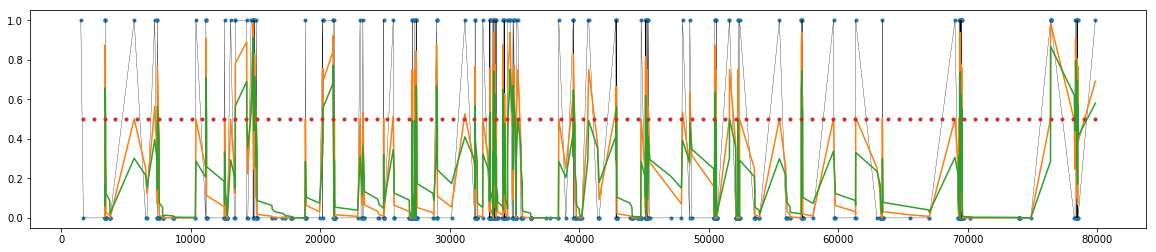

In [204]:
plt.figure(figsize=(20,4))
plt.plot(idx[idx1], acc, '.')
plt.plot(idx[idx1], acc, 'k-', lw=0.3)
plt.plot(idx[idx1], ta.EMA(acc.flatten(), 3))
plt.plot(idx[idx1], ta.EMA(acc.flatten(), 6))
plt.plot(newmodel, 0.5*np.ones(len(newmodel)), '.')
#plt.xlim(30000, 50000)

In [201]:
acc

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1.,
       0., 0., 1., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       0., 1., 1., 0., 0.

In [199]:
print(metrics.classification_report(ys, ypred))

             precision    recall  f1-score   support

       -1.0       0.20      0.32      0.25      2092
        0.0       0.69      0.70      0.70      8833
        1.0       0.21      0.07      0.11      1997

avg / total       0.54      0.54      0.53     12922

